# A graduating statistician at the Particle Physics Playground - Part II

## Activities 02 and 03: a new approach is required that is not limited to single tasks

Activities 02 and 03 represented for me a quality leap compared to Activities 00 and 01, due to the complexity of the code required to carry them out more efficiently (at least in terms of code  amount). Working through them opened the doors to a more committed way to code, which passed from being the mere execution of an isolated task to becoming a comprehensive strategy capable to speed up data manipulation, extraction and computation in the context of particle reconstruction. In other words, I decided to approach the last two activities by defining functions capable to:
1) selecting the collisions (from the list created by **pps.get_collisions**) which generated the minimum number of particles with a specified charge (if applicable) required by the decay mode (function **get_min_particles**);

2) forming, for each selected collision, all the possible combinations of particles in accord with the specified decay mode (function **get_combinations**);

3) extracting and summing, for each particle combination, the energy and momentum in the $x$-, $y$- and $z$-directions of the daughter particles to determine the energy, magnitude of momentum and mass of the parent particle (function **get_parent_attributes**).

The choice of creating ad hoc functions was motivated mainly by the presence of multiple datasets on which the same reconstruction process had to be performed, but the task soon became a self-challenge where I tried to creatively build something new by putting together all my knowledge as a junior Pythonist. What have I learnt from this? That, to create something new, we shouldn't be afraid to dare!

## Getting ready for Activities 02 and 03

Besides the ordinary modules that I imported for the first two activities, specific functions from two additional modules will be imported directly by the code that defines the aforementioned functions. These are the function **deepcopy** from the **copy** module (to ensure the preservation of the original list and the generation of a deepcopy of it on which the function **get_min_particles** will operate) and the functions **combinations()** and **product()** from the **itertools** module (which will play a primary role when defining the function **get_combinations**).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pps_tools as pps
import pandas as pd
from os import chdir
path = 'C:\\Users\\ICON\\Desktop\\Python projects\\Particle Physics Playground\\playground-master\\data'
chdir(path)
%matplotlib notebook

C:\Users\ICON\anaconda3\lib\site-packages\h5hep-0.9-py3.8.egg\h5hep\write.py:423: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\ICON\anaconda3\lib\site-packages\h5hep-0.9-py3.8.egg\h5hep\write.py:423: SyntaxWarning: "is not" with a literal. Did you mean "!="?


Then the functions **get_min_particles**, **get_combinations** and **get_parent_mass** are defined, as shown below.

### Defining get_min_particles

As mentioned earlier, the aim of this function is retaining only the collisions that produced the minimum number of charged particles required by the decay mode of interest. It is important to specify that it is designed to work on lists of collisions obtained with the **pps.get_collisions** function, as it selects collisions depending on information retrieved from the list-dictionary structure generated therein.
When designing **get_min_particles**, I aimed to allow for the maximum possible flexibility in terms of particle features. In fact, it is possible to specify as many particle types as needed, with the related charge (taking into account the fact that some decay products, like jets, do not hold this feature at all) and the number of times they feature in the decay mode and hence they are to be picked up to form the combinations. The function gives an output message to inform the user about the number of collisions in the final list and the number of collisions in the original list that were not selected.

In [2]:
def get_min_particles(collisions_list, particles, charge, min_num):
    """It first checks 'collisions_list' to search for collisions that generated fewer particles of the specified kind and charge 
    than required, giving an appropriate output message. If this is the case, it creates a new list containing only the collisions 
    where the minimum required number of those particles was generated. The argument 'particles' is a list of the particle types 
    involved in the decay mode (each type must be specified as a string such as 'pions' and, if it appears in the decay mode with 
    different charges, the string must be repeated once for each charge type). The argument 'charge' is the list of the charges 
    corresponding to the particles specified in the 'particles' argument (each charge type must be  specified either as -1, 0, 1 
    or np.nan if the particle has no charge, like for jets). The argument 'min_num' is the list of the number of times each 
    charged particle appears in the decay mode. The function works on a deep copy of the original list."""
    tuples = list(zip(particles,charge,min_num))
    from copy import deepcopy
    collisions_list_copy = deepcopy(collisions_list)
    all_indices_collisions_with_fewer_particles = []
    for index,tupl in enumerate(tuples):
        particles = tupl[0]
        charge = tupl[1]
        min_num = tupl[2]
        indices_collisions_with_fewer_particles = []
        for index,collision in enumerate(collisions_list_copy):
            all_particles = collision[particles]
            if (np.isnan(charge) == True and len(all_particles) < min_num):                
                indices_collisions_with_fewer_particles.append(index)
            elif np.isnan(charge) == False: 
                count_correctly_charged_particles = sum(map(lambda particle : particle['q'] == charge, all_particles))
                if count_correctly_charged_particles < min_num:
                    indices_collisions_with_fewer_particles.append(index)
        all_indices_collisions_with_fewer_particles.append(indices_collisions_with_fewer_particles)
    all_indices_flattened_list = [item for sublist in all_indices_collisions_with_fewer_particles for item in sublist]
    unique_indices_list = list(set(all_indices_flattened_list))
    if len(unique_indices_list) == 0:
        print('There are no collisions where the number of particles of some kind and charge is less than required.')
    else: 
        print('There are ' + str(len(unique_indices_list)) 
              + ' collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.')
    collisions_list_new = []
    for index,collision in enumerate(collisions_list_copy):
        if index not in unique_indices_list: collisions_list_new.append(collision)
    if len(collisions_list_new) == len(collisions_list_copy) - len(unique_indices_list):
            print('The selection process terminated and the new list was created. It contains ' + str(len(collisions_list_new)) + 
                  ' collisions of ' + str(len(collisions_list_copy)) + ' in the original list, following the removal of '
                  + str(len(unique_indices_list)) + ' elements.')
    else: print('An error occurred.')
    return collisions_list_new

### Defining get_combinations

This function is designed to create all possible particle combinations using the particles generated by the collisions previously selected by **get_min_particles**. I gave it the same flexibility allowed for **get_min_particles**, in that it uses lists where we can specify the particle types, charges and numbers required by the decay mode. It first uses **itertools.combinations** to form, for each collision, all possible combinations (of the size specified by the corresponding entry in the *num* list) from particles of the same type and charge. This action is repeated for all the types of charged particles, creating a list of combinations (stored as tuples) for each. It then uses **itertools.product** to perform the Cartesian product between each combination of particles of a certain type and charge with all the combinations of particles of the other types and charges. After suitable flattening, the final object is a list of lists, where each sublist is a combination of particles from which data can readily be extracted for the reconstruction process. The function gives an output message to inform the user about the number of combinations that were formed. 

In [3]:
def get_combinations(collisions_list,particles,charge,num):
    """It creates, for each collision selected by 'get_min_particles', all possible combinations of the particles specified by the 
    decay mode. The argument 'particles' is a list of the particle types involved in the decay mode (each type must be 
    specified as a string such as 'pions' and, if it appears in the decay mode with different charges, the string must be 
    repeated once for each charge type). The argument 'charge' is the list of the charges corresponding to the particles 
    specified in the 'particles' argument (each charge type must be specified either as -1, 0, 1 or np.nan if the particle has 
    no charge, like for jets). The argument 'num' is the list of the number of times each charged particle appears in the decay 
    mode. It returns a list of lists, where each sublist contains one combination of particles. The type of particles in each 
    sublist cannot be retrieved."""
    tuples = list(zip(particles,charge,num))
    from itertools import combinations, product
    decay_combinations = []
    for collision in collisions_list:   
        all_combinations = []
        for index,tupl in enumerate(tuples):
            particles = tupl[0]
            charge = tupl[1]
            num = tupl[2]
            all_particles = []
            for particle in collision[particles]:
                if np.isnan(charge) == True:
                    all_particles.append(particle)
                else: 
                    if particle['q'] == charge:
                        all_particles.append(particle)
            particle_combinations = list(combinations(all_particles, num))
            all_combinations.append(particle_combinations)
        decay_combinations_per_collision = list(product(*all_combinations))
        decay_combinations.append(decay_combinations_per_collision)
    flattened_decay_combinations = [item for sublist in decay_combinations for item in sublist]
    decay_combinations_final = []
    for tup in flattened_decay_combinations:
        single_combination = [item for subtuple in tup for item in subtuple]
        decay_combinations_final.append(single_combination)
    print('All possible combinations have been formed and the new list was created. It contains ' + 
          str(len(decay_combinations_final)) + ' combinations.')
    return decay_combinations_final

### Defining get_parent_attributes

Arguably the most straightforward function to define, it uses the list of combinations generated by **get_combinations** to calculate the energy, magnitude of momentum and mass of the reconstructed particles. It then converts the resulting lists into a dataframe. The final output message includes the number of records in the dataframe and that of NaN values in the *mass* column, if any. I shall specify that, while computing masses alone would be enough for the reconstruction process, I decided to include energies and magnitudes of momentum as well to be able to check if possible NaN values arose from magnitudes of momentum greater than energies. 

In [4]:
def get_parent_attributes(decay_combinations_list):
    '''It computes the mass of the parent particle for each decay combination in the list created by the function 
    'get_combinations'.'''
    parent_energy_list = []
    parent_magnitude_momentum_list = []
    parent_mass_list = []
    for combination in decay_combinations_list:
        all_energies = []
        all_px = []
        all_py = []
        all_pz = []
        for particle in combination:
            energy = particle['e']
            px = particle['px']
            py = particle['py']
            pz = particle['pz']
            all_energies.append(energy)
            all_px.append(px)
            all_py.append(py)
            all_pz.append(pz)
        parent_energy = sum(all_energies)
        parent_px = sum(all_px)
        parent_py = sum(all_py)
        parent_pz = sum(all_pz)
        parent_magnitude_momentum = np.sqrt(parent_px**2 + parent_py**2 + parent_pz**2)
        parent_mass = np.sqrt(parent_energy**2 - parent_magnitude_momentum**2)
        parent_energy_list.append(parent_energy)
        parent_magnitude_momentum_list.append(parent_magnitude_momentum)
        parent_mass_list.append(parent_mass)
    parent_attributes_df = pd.DataFrame(list(zip(parent_energy_list,parent_magnitude_momentum_list,parent_mass_list)), columns = ['energy','magnitude of momentum','mass'])
    print('The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains '
          + str(parent_attributes_df.shape[0]) + ' values with '
          + str(parent_attributes_df['mass'].isna().sum()) + ' NaN values in the mass column.')
    return parent_attributes_df

## Activity 02: Reconstructing $D$ mesons
(The relevant Jupyter notebook can be dowloaded from this link: https://drive.google.com/file/d/1OmzOOn_m9K_HPuNaHnA9Jd0cXtWpFsqb/view)

In this activity, I will approach the task of reconstructing $D^+$ and $D^0$ mesons using first Monte Carlo simulated data. In particular, I will reconstruct $D^0$ mesons through four different decay modes, namely,
1) $D^0 \rightarrow K^- \pi^+$,

2) $D^0 \rightarrow K^- \pi^+ \pi^0,$

3) $D^0 \rightarrow K^+ K^-, $

4) $D^0 \rightarrow \pi^+ \pi^-,$

while $D^+$ will be reconstructed via the $K^- \pi^+ \pi^+$ decay mode. The next challenge will be attempting to reconstruct the same particles using real data from the CLEO detector and the same decay modes. While performing these tasks may look redundant at times, it is a chance to see the newly-created functions in action!

The strategy I will follow consists in applying in turn each of the three functions I defined above to one dataset at a time, then plotting the resulting invariant masses. For $D^0$ mesons, I shall plot superimposed step histograms so as to compare the results obtained from the different datasets and decay modes. It will be interesting to use the same plotting layout for the real CLEO data to check whether there is any significant peak and which decay mode it pertains to.

### Reconstructing $D^+$ mesons with decay mode $K^- \pi^+ \pi^+$ from MC simulated data

In [5]:
# The file containing the MC simulated data about the decay of positve D mesons into one negative kaon and two positive pions is downloaded, the list of collisions created...
pps.download_from_drive('Single_Dp_to_Kpipi_ISR_LARGE.hdf5')
infile = 'data/Single_Dp_to_Kpipi_ISR_LARGE.hdf5'
collisions_MC_Dp = pps.get_collisions(infile,experiment='CLEO',verbose=False)
print(len(collisions_MC_Dp), " collisions")  


Building a simplified interface to the events...

Building the indices...
Built the indices!
Data is read in and input file is closed.
Reading in event  0
9963  collisions


In [6]:
# ...and the functions applied.
collisions_MC_Dp_filtered = get_min_particles(collisions_MC_Dp,['pions','kaons'],[1,-1],[2,1])
combinations_kpipi = get_combinations(collisions_MC_Dp_filtered,['pions','kaons'],[1,-1],[2,1])
Dp_mesons_MC_df = get_parent_attributes(combinations_kpipi)

There are 6904 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 3059 collisions of 9963 in the original list, following the removal of 6904 elements.
All possible combinations have been formed and the new list was created. It contains 9502 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 9502 values with 0 NaN values in the mass column.


In [7]:
# Let's now inspect the dataframe!
print(Dp_mesons_MC_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9502 entries, 0 to 9501
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   energy                 9502 non-null   float64
 1   magnitude of momentum  9502 non-null   float64
 2   mass                   9502 non-null   float64
dtypes: float64(3)
memory usage: 222.8 KB
None


The above output tells us that, reassuringly, there are no invalid entries in any of the columns and the data type is *float64* in all cases, so... let's plot! The chosen range includes masses between 1.8 and 2 $GeV/c^2$, where the unique peak is clearly visible. Since we are interested exclusively in the reconstruction task, I shall not explore the dataset further by considering summary statistics.

<IPython.core.display.Javascript object>


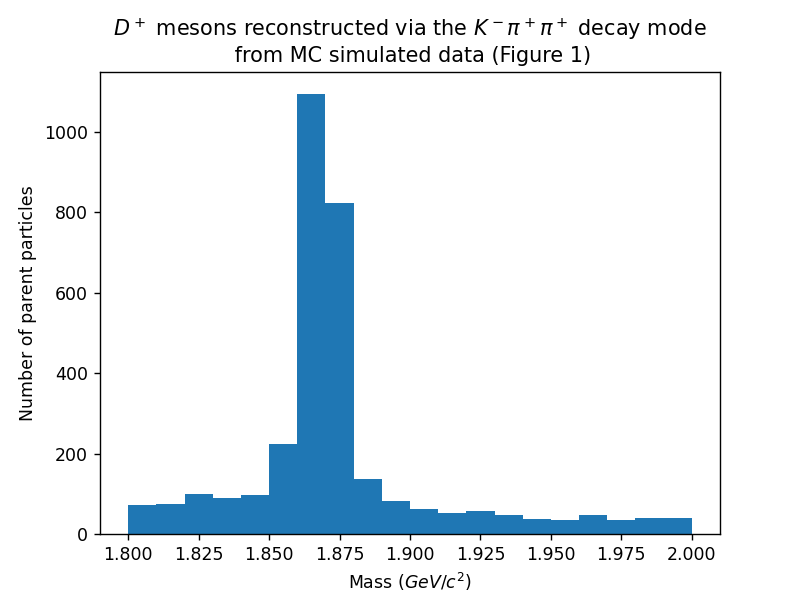

<function matplotlib.pyplot.show(block=None)>

In [61]:
fig,ax = plt.subplots()
ax.hist(Dp_mesons_MC_df['mass'],range = (1.8,2),bins=20)
ax.set_title('$D^+$ mesons reconstructed via the $K^-\pi^+\pi^+$ decay mode \n from MC simulated data (Figure 1)')
ax.set_xlabel('Mass ($GeV/c^2$)')
ax.set_ylabel('Number of parent particles')
plt.show

The histogram in Figure 1 shows a very clear, unique peak at about 1.87 $GeV/c^2$, very close to the actual mean mass of $D^+$ mesons (1.8696 $GeV/c^2$ according to Wikipedia). It therefore appears that the reconstruction process succeeded in detecting $D^+$ mesons through the $K^-\pi^+\pi^+$ decay mode, at least for simulated data.

### Reconstructing $D^0$ mesons from MC simulated data

#### 1) $K^- \pi^+ $ decay mode

In [9]:
# The file containing the MC simulated data about the decay of neutral D mesons into one negative kaon and one positive pion is downloaded, the list of collisions created...
pps.download_from_drive('Single_D0_to_Kpi_LARGE.hdf5')
infile = 'data/Single_D0_to_Kpi_LARGE.hdf5'
collisions_MC_D0_Kpi = pps.get_collisions(infile,experiment='CLEO',verbose=False)
print(len(collisions_MC_D0_Kpi), " collisions") 


Building a simplified interface to the events...

Building the indices...
Built the indices!
Data is read in and input file is closed.
Reading in event  0
Reading in event  10000
Reading in event  20000
Reading in event  30000
Reading in event  40000
49789  collisions


In [10]:
# ...and the functions applied.
collisions_MC_D0_Kpi_filtered = get_min_particles(collisions_MC_D0_Kpi,['pions','kaons'],[1,-1],[1,1])
combinations_D0_kpi = get_combinations(collisions_MC_D0_Kpi_filtered,['pions','kaons'],[1,-1],[1,1])
D0_Kpi_MC_df = get_parent_attributes(combinations_D0_kpi)

There are 16491 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 33298 collisions of 49789 in the original list, following the removal of 16491 elements.
All possible combinations have been formed and the new list was created. It contains 71811 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 71811 values with 0 NaN values in the mass column.


#### 2) $K^- \pi^+ \pi^0 $ decay mode

In [11]:
# The file containing the MC simulated data about the decay of neutral D mesons into one negative kaon and two pions, one positive and one neutral, is downloaded, the list of collisions created...
pps.download_from_drive('Single_D0_to_Kpipi0_ISR_LARGE.hdf5')
infile = 'data/Single_D0_to_Kpipi0_ISR_LARGE.hdf5'
collisions_MC_D0_Kpipi0 = pps.get_collisions(infile,experiment='CLEO',verbose=False)
print(len(collisions_MC_D0_Kpipi0), " collisions")  


Building a simplified interface to the events...

Building the indices...
Built the indices!
Data is read in and input file is closed.
Reading in event  0
9783  collisions


In [12]:
# ...and the functions applied.
collisions_MC_D0_Kpipi0_filtered = get_min_particles(collisions_MC_D0_Kpipi0,['pions','pions','kaons'],[1,0,-1],[1,1,1])
combinations_D0_kpipi0 = get_combinations(collisions_MC_D0_Kpipi0_filtered,['pions','pions','kaons'],[1,0,-1],[1,1,1])
D0_Kpipi0_MC_df = get_parent_attributes(combinations_D0_kpipi0)

There are 9780 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 3 collisions of 9783 in the original list, following the removal of 9780 elements.
All possible combinations have been formed and the new list was created. It contains 11 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 11 values with 0 NaN values in the mass column.


It looks like there are far too little particle combinations here to deduce something insightful, so the masses reconstructed via this decay mode will not be plotted.

#### 3) $K^+ K^- $ decay mode

In [13]:
# The file containing the MC simulated data about the decay of neutral D mesons into two kaons, one positive and one negative, is downloaded, the list of collisions created...
pps.download_from_drive('Single_D0_to_KK_ISR_LARGE.hdf5')
infile = 'data/Single_D0_to_KK_ISR_LARGE.hdf5'
collisions_MC_D0_KK = pps.get_collisions(infile,experiment='CLEO',verbose=False)
print(len(collisions_MC_D0_KK), " collisions") 


Building a simplified interface to the events...

Building the indices...
Built the indices!
Data is read in and input file is closed.
Reading in event  0
9705  collisions


In [14]:
# ...and the functions applied.
collisions_MC_D0_KK_filtered = get_min_particles(collisions_MC_D0_KK,['kaons','kaons'],[1,-1],[1,1])
combinations_D0_KK = get_combinations(collisions_MC_D0_KK_filtered,['kaons','kaons'],[1,-1],[1,1])
D0_KK_MC_df = get_parent_attributes(combinations_D0_KK)

There are 4206 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 5499 collisions of 9705 in the original list, following the removal of 4206 elements.
All possible combinations have been formed and the new list was created. It contains 6666 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 6666 values with 0 NaN values in the mass column.


#### 4) $\pi^+ \pi^- $ decay mode

In [15]:
# The file containing the MC simulated data about the decay of neutral D mesons into two pions, one positive and one negative, is downloaded, the list of collisions created...
pps.download_from_drive('Single_D0_to_pipi_ISR_LARGE.hdf5')
infile = 'data/Single_D0_to_pipi_ISR_LARGE.hdf5'
collisions_MC_D0_pipi = pps.get_collisions(infile,experiment='CLEO',verbose=False)
print(len(collisions_MC_D0_pipi), " collisions")


Building a simplified interface to the events...

Building the indices...
Built the indices!
Data is read in and input file is closed.
Reading in event  0
9458  collisions


In [16]:
collisions_MC_D0_pipi_filtered = get_min_particles(collisions_MC_D0_pipi,['pions','pions'],[1,-1],[1,1])
combinations_D0_pipi = get_combinations(collisions_MC_D0_pipi_filtered,['pions','pions'],[1,-1],[1,1])
D0_pipi_MC_df = get_parent_attributes(combinations_D0_pipi)

There are 288 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 9170 collisions of 9458 in the original list, following the removal of 288 elements.
All possible combinations have been formed and the new list was created. It contains 49986 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 49986 values with 0 NaN values in the mass column.


It is now time to plot the masses reconstructed via the $K^- \pi^+$, $K^+ K^-$ and $\pi^+ \pi^-$ decay modes! As said, the results from the $K^- \pi^+ \pi^0$ decay mode will not be accounted for due to the too small sample size (only 11 values). Two plotting ranges have been chosen: the first, comprised between 1.5 and 2 $GeV/c^2$, shows the peak of the masses of reconstructed $D^+$ mesons (Figure 2) and the second, comprised between 0.2 and 1.5 $GeV/c^2$, shows two minor (and unexpected) peaks (Figure 3).

<IPython.core.display.Javascript object>


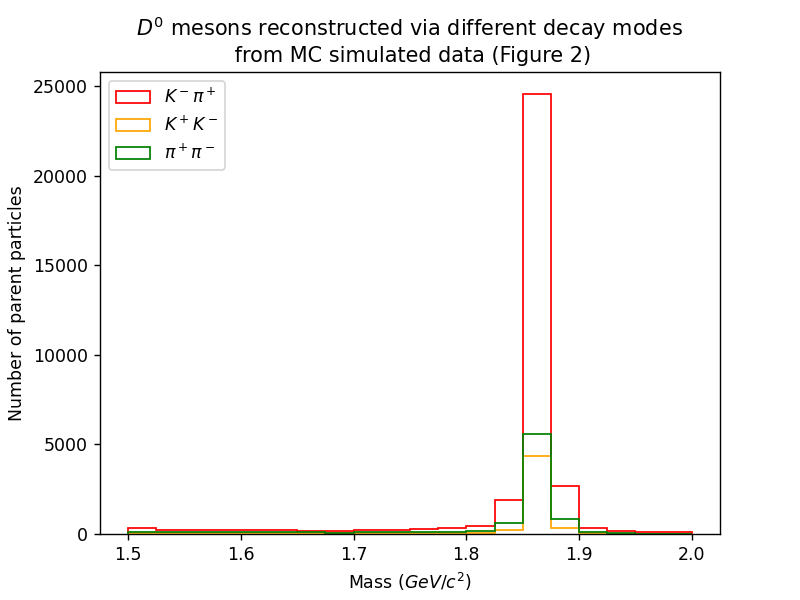

<function matplotlib.pyplot.show(block=None)>

In [62]:
fig,ax = plt.subplots()
ax.hist(D0_Kpi_MC_df['mass'], range = (1.5,2), histtype = 'step', label = '$K^- \pi^+$', bins = 20, color = 'red')
ax.hist(D0_KK_MC_df['mass'], range = (1.5,2), histtype = 'step', label = '$K^+ K^-$', bins = 20, color = 'orange')
ax.hist(D0_pipi_MC_df['mass'], range = (1.5,2), histtype = 'step', label = '$\pi^+ \pi^-$', bins = 20, color = 'green')
ax.set_title('$D^0$ mesons reconstructed via different decay modes \n from MC simulated data (Figure 2)')
ax.set_xlabel('Mass ($GeV/c^2$)')
ax.set_ylabel('Number of parent particles')
ax.legend(loc = 'upper left')
plt.show

The histogram in Figure 2 leaves no doubt that the reconstruction process of $D^0$ mesons succeeded: the peak occurred exactly where expected, at about 1.86 $GeV/c^2$, comparing with a real mean value of 1.8648 $GeV/c^2$ (according to Wikipedia). We can observe that the decay mode through which the highest number of $D^0$ mesons was reconstructed is the $K^- \pi^+$ mode (the peak comprises about 25000 units), while the $K^+K^-$ and $\pi^+\pi-$ modes (which performed pretty similarly, with the latter having produced a slightly higher peak of about 6000 units) captured a lower number of parent particles.

<IPython.core.display.Javascript object>


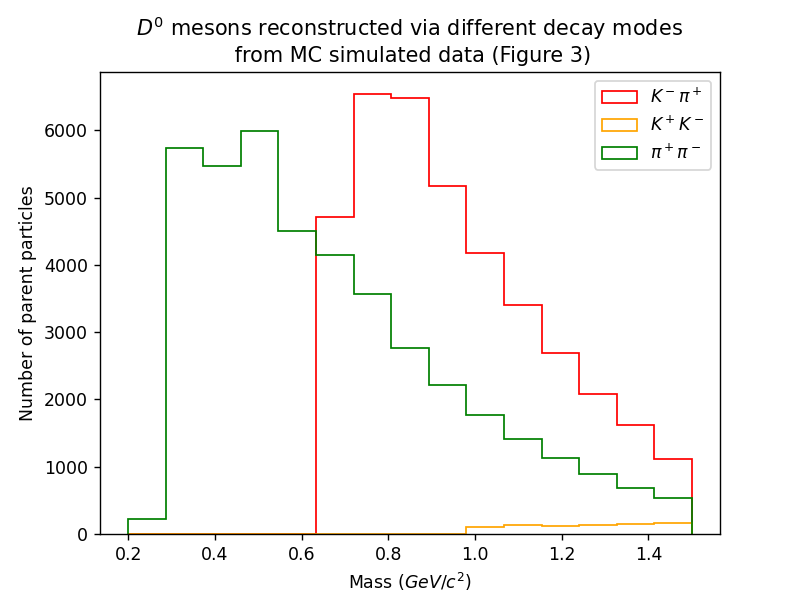

<function matplotlib.pyplot.show(block=None)>

In [63]:
fig,ax = plt.subplots()
ax.hist(D0_Kpi_MC_df['mass'], range = (0.2,1.5), histtype = 'step', label = '$K^- \pi^+$', bins = 15, color = 'red')
ax.hist(D0_KK_MC_df['mass'], range = (0.2,1.5), histtype = 'step', label = '$K^+ K^-$', bins = 15, color = 'orange')
ax.hist(D0_pipi_MC_df['mass'], range = (0.2,1.5), histtype = 'step', label = '$\pi^+ \pi^-$', bins = 15, color = 'green')
ax.set_title('$D^0$ mesons reconstructed via different decay modes \n from MC simulated data (Figure 3)')
ax.set_xlabel('Mass ($GeV/c^2$)')
ax.set_ylabel('Number of parent particles')
ax.legend(loc = 'upper right')
plt.show

It is very interesting to note that, while the reconstruction process succeeded to reconstruct $D^0$ mesons, this is not the only peak that could be identified. There are two other smaller peaks generated by the parent particles reconstructed via $K^- \pi^+$ and $\pi^- \pi^+$ decay modes, respectively a bimodal peak centred at 0.4 $GeV/c^2$ and a peak at 0.8 $GeV/c^2$. These are lower in height (about 6000 and 6500 units compared to the 25000 of the peak for the masses of $D^0$ mesons via the $K^- \pi^+$ mode). However, comparing the mass values at which these minor peaks occur with those of the known particles in the Standard Model of Elementary Particles (https://en.wikipedia.org/wiki/Subatomic_particle#/media/File:Standard_Model_of_Elementary_Particles.svg), I couldn't find any correspondence. It may be hypothesised that these peaks correspond to the total mass of multiple particles that in turn decayed into kaons and pions, or that they are due to random variation.

### Reconstructing parent particles via the different decay modes using the CLEO data

The same decay modes are now used to try to reconstruct $D^0$ and $D^+$ mesons using real data from the CLEO detector. How will results compare with those depicted in Figure 1, 2 and 3?

In [19]:
# The file containing the real data from the CLEO detector is downloaded, the list of collisions created.
pps.download_from_drive('data31_100k_LARGE.hdf5')
infile = 'data/data31_100k_LARGE.hdf5'
collisions_CLEO = pps.get_collisions(infile,experiment='CLEO',verbose=False)
print(len(collisions_CLEO), " collisions")  


Building a simplified interface to the events...

Building the indices...
Built the indices!
Data is read in and input file is closed.
Reading in event  0
Reading in event  10000
Reading in event  20000
Reading in event  30000
Reading in event  40000
Reading in event  50000
Reading in event  60000
Reading in event  70000
Reading in event  80000
Reading in event  90000
Reading in event  100000
100001  collisions


#### 1) $K^- \pi^+\pi^+$ decay mode for $D^+$ mesons

In [20]:
# The functions are now applied for the decay mode of positive D mesons, involving one negative kaon and two positive pions.
collisions_CLEO_Kpipi_filtered = get_min_particles(collisions_CLEO,['pions','kaons'],[1,-1],[2,1])
combinations_CLEO_Kpipi = get_combinations(collisions_CLEO_Kpipi_filtered,['pions','kaons'],[1,-1],[2,1])
Kpipi_CLEO_df = get_parent_attributes(combinations_CLEO_Kpipi)

There are 97172 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 2829 collisions of 100001 in the original list, following the removal of 97172 elements.
All possible combinations have been formed and the new list was created. It contains 21452 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 21452 values with 0 NaN values in the mass column.


#### 2) $K^- \pi^+$ decay mode for $D^0$ mesons

In [21]:
# The functions are now applied for the first decay mode of neutral D mesons, involving one negative kaon and one positive pion.
collisions_CLEO_Kpi_filtered = get_min_particles(collisions_CLEO,['pions','kaons'],[1,-1],[1,1])
combinations_CLEO_Kpi = get_combinations(collisions_CLEO_Kpi_filtered,['pions','kaons'],[1,-1],[1,1])
Kpi_CLEO_df = get_parent_attributes(combinations_CLEO_Kpi)

There are 96147 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 3854 collisions of 100001 in the original list, following the removal of 96147 elements.
All possible combinations have been formed and the new list was created. It contains 10788 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 10788 values with 0 NaN values in the mass column.


#### 3) $K^- \pi^+ \pi^0$ decay mode for $D^0$ mesons

In [22]:
# The functions are applied for the second decay mode of neutral D mesons, involving one negative kaon and two pions, one positive and one neutral.
collisions_CLEO_Kpipi0_filtered = get_min_particles(collisions_CLEO,['pions','pions','kaons'],[1,0,-1],[1,1,1])
combinations_CLEO_Kpipi0 = get_combinations(collisions_CLEO_Kpipi0_filtered,['pions','pions','kaons'],[1,0,-1],[1,1,1])
Kpipi0_CLEO_df = get_parent_attributes(combinations_CLEO_Kpipi0)

There are 99986 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 15 collisions of 100001 in the original list, following the removal of 99986 elements.
All possible combinations have been formed and the new list was created. It contains 247 combinations.


<ipython-input-4-b275bf6f04db>:26: RuntimeWarning: invalid value encountered in sqrt
  parent_mass = np.sqrt(parent_energy**2 - parent_magnitude_momentum**2)


The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 247 values with 108 NaN values in the mass column.


#### 4) $K^+ K^-$ decay mode for $D^0$ mesons

In [23]:
# The functions are applied for the third decay mode of neutral D mesons, involving two kaons, one positive and one negative.
collisions_CLEO_KK_filtered = get_min_particles(collisions_CLEO,['kaons','kaons'],[1,-1],[1,1])
combinations_CLEO_KK = get_combinations(collisions_CLEO_KK_filtered,['kaons','kaons'],[1,-1],[1,1])
KK_CLEO_df = get_parent_attributes(combinations_CLEO_KK)

There are 99165 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 836 collisions of 100001 in the original list, following the removal of 99165 elements.
All possible combinations have been formed and the new list was created. It contains 924 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 924 values with 0 NaN values in the mass column.


#### 5) $\pi^+ \pi^-$ decay mode for $D^0$ mesons

In [24]:
# The functions are applied for the third decay mode of neutral D mesons, involving two piins, one positive and one negative.
collisions_CLEO_pipi_filtered = get_min_particles(collisions_CLEO,['pions','pions'],[1,-1],[1,1])
combinations_CLEO_pipi = get_combinations(collisions_CLEO_pipi_filtered,['pions','pions'],[1,-1],[1,1])
pipi_CLEO_df = get_parent_attributes(combinations_CLEO_pipi)

There are 20205 collisions in the initial list with fewer particles of some type and charge, so the selection process will be initialised.
The selection process terminated and the new list was created. It contains 79796 collisions of 100001 in the original list, following the removal of 20205 elements.
All possible combinations have been formed and the new list was created. It contains 569447 combinations.
The energy, magnitude of momentum and mass of the parent particles were calculated and the dataframe created. It contains 569447 values with 0 NaN values in the mass column.


Inspecting the outputs above, it is worth appreciating how reconstructing particles through the different decay modes using the same dataset yielded very different results in terms of number of collisions selected and number of combinations that could be formed. Here are the number of combinations obtained by each modes, presented in decreasing order:

1) 569 447 combinations (and no invalid masses) for the $\pi^+\pi^-$ decay mode for $D^0$ mesons,

2) 21 452 combinations (and no invalid masses) for the $K^-\pi^+\pi^+$ decay mode for $D^+$ mesons,

3) 10 788 combinations (and no invalid masses) for the $K^-\pi^+$ decay mode for $D^0$ mesons,

4) 924 combinations (and no invalid masses) for the $K^+K^-$ decay mode for $D^0$ mesons,

5) 247 combinations (and 108 invalid masses) for the $K^-\pi^+\pi^0$ decay mode for $D^0$ mesons.

These figures give some indication of what we might expect from the plot: arguably, the particles that are most likely to be successfully reconstructed might be the $D^0$ mesons via the $\pi^+\pi^-$ decay mode, given the high number of combinations that could be formed. $D^0$ mesons via the $K^+K^-$ and $K^-\pi^+\pi^0$ aren't likely to be significant, with only 924 and 139 valid masses respectively.

Before plotting, I shall inspect the summary statistics to check the scale of the masses produced by the different datasets. This is useful given that plots from five datasets are to be superimposed and they might cover very different ranges for all to be represented against the same pair of axes.

In [25]:
print(pipi_CLEO_df['mass'].describe())
print(Kpipi_CLEO_df['mass'].describe())
print(Kpi_CLEO_df['mass'].describe())
print(KK_CLEO_df['mass'].describe())
print(Kpipi0_CLEO_df['mass'].describe())

count    569447.000000
mean          0.501483
std           0.400599
min           0.279157
25%           0.330685
50%           0.375574
75%           0.537449
max          49.120987
Name: mass, dtype: float64
count    21452.000000
mean         1.674104
std          1.151223
min          0.775705
25%          1.127167
50%          1.374953
75%          1.807970
max         30.533626
Name: mass, dtype: float64
count    10788.000000
mean         1.098148
std          0.569763
min          0.633524
25%          0.794631
50%          0.950601
75%          1.246352
max         13.529089
Name: mass, dtype: float64
count    924.000000
mean       1.681323
std        0.568970
min        0.990507
25%        1.337108
50%        1.612409
75%        1.879964
max        8.175453
Name: mass, dtype: float64
count    1.390000e+02
mean     1.808644e+16
std      1.032508e+16
min      8.283409e+15
25%      8.283409e+15
50%      2.060532e+16
75%      2.060532e+16
max      1.144431e+17
Name: mass, dtype: f

It can immediately be observed that the masses of the parent particles reconstructed via the $K^-\pi^+\pi^0$ decay mode have extremely large values compared to those reconstructed via the other decay modes. Since the sample size is very small, these masses will not be investigated visually. Prior visual exploration revealed also that the peak generated by the particles reconstructed via the $\pi^+\pi^-$ decay mode is very high compared to the peaks for the other modes, due to the substantial number of combinations (and hence of parent particles) it yielded. I will therefore plot these data separately (Figure 4), not to obscure the pattern in the masses from the $K^-\pi^+\pi^+$, $K^+K^-$ and $K^-\pi^+$ decay modes. Since these three modes are instead reasonably comparable in range and size, there is no point not in plotting them together (Figure 5). The histograms related to the same decay mode will be coloured in the same way both for MC simulated data and real CLEO data, so as to facilitate comparisons.

<IPython.core.display.Javascript object>


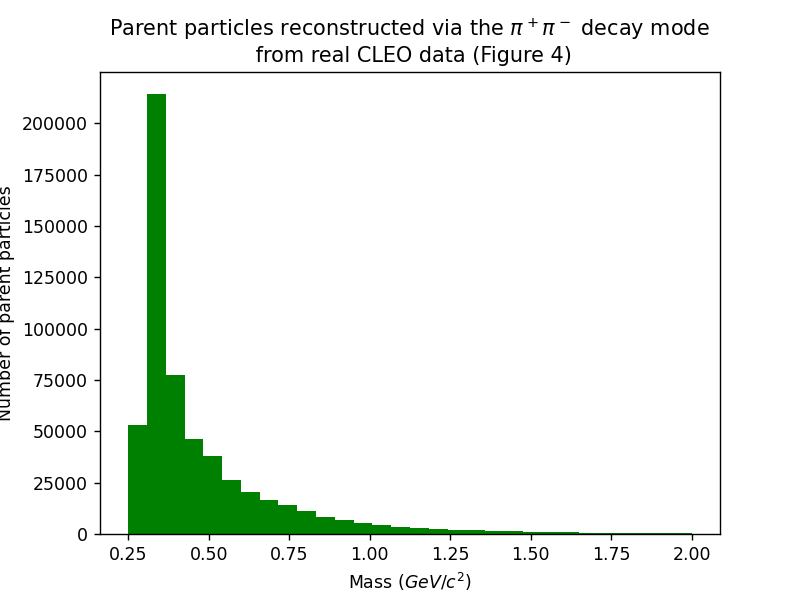

<function matplotlib.pyplot.show(block=None)>

In [64]:
fig,ax = plt.subplots()
ax.hist(pipi_CLEO_df['mass'], range = (0.25,2),  bins = 30,  color = 'green')
ax.set_title('Parent particles reconstructed via the $\pi^+ \pi^-$ decay mode \n from real CLEO data (Figure 4)')
ax.set_xlabel('Mass ($GeV/c^2$)')
ax.set_ylabel('Number of parent particles')
plt.show

Differently from what expected, the peak generated by the masses of particles reconstructed via the $\pi^+\pi^-$ mode is not located at 1.86 $GeV/c^2$ (the approximate location of $D^0$ mesons), rather at about 0.3 $GeV/c^2$. Interestingly, this is the same position at which the unexpected peak of masses of parent particles reconstructed through the same decay mode, but from MC simulated data, occurred (see Figure 3). We may interpret this as an indication that the peak may not be caused by simple random variation: it seems to be the clue of a particle! At this stage, however, I lack the knowledge and analysis tools necessary to infer more deeply about this issue.

<IPython.core.display.Javascript object>


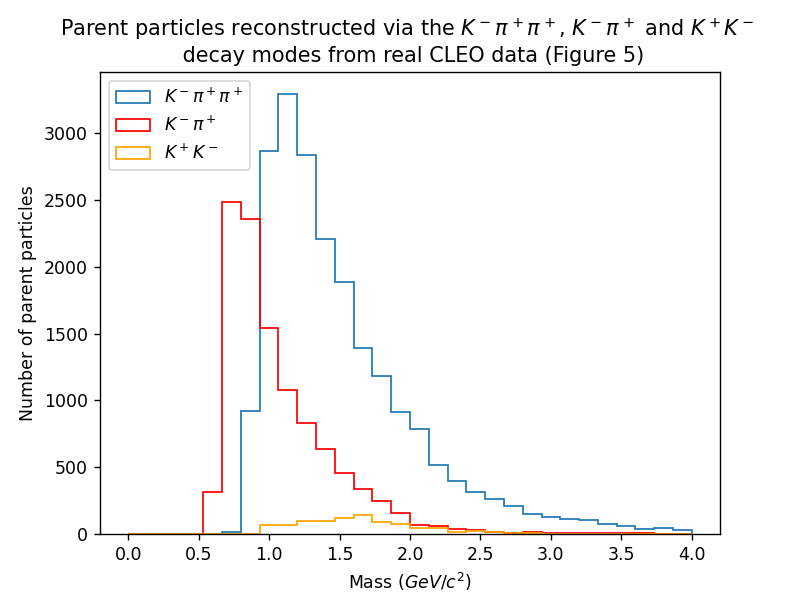

<function matplotlib.pyplot.show(block=None)>

In [65]:
fig,ax = plt.subplots()
ax.hist(Kpipi_CLEO_df['mass'], range = (0,4), bins = 30, histtype = 'step', label = '$K^- \pi^+\pi^+$', color = '#1f77b4')
ax.hist(Kpi_CLEO_df['mass'], range = (0,4), bins = 30, histtype = 'step', label = '$K^- \pi^+$', color = 'red')
ax.hist(KK_CLEO_df['mass'], range = (0,4),bins = 30, histtype = 'step', label = '$K^+ K^-$', color = 'orange')
ax.set_title('Parent particles reconstructed via the $K^- \pi^+\pi^+$, $K^- \pi^+$ and $K^+ K^-$ \n decay modes from real CLEO data (Figure 5)')
ax.set_xlabel('Mass ($GeV/c^2$)')
ax.set_ylabel('Number of parent particles')
ax.legend(loc = 'upper left')
plt.show

Like in the histogram in Figure 4, none of the peaks of the masses of particles reconstructed via the decay modes depicted here corresponds to the mass of $D^0$ or $D^+$ mesons. The peak related to the $K^-\pi^+$ decay mode is located at about 0.8 $GeV/c^2$, right as the peak in the corresponding histogram from MC simulated data: another suggestion of an actual particle rather than simple random variation! The modest peak for the $K^+K^-$ decay mode, located at about 1.66 $GeV/c^2$, is not so far from the mean value of the mass of $D^0$ mesons. It is possible that these parent particles do correspond to $D^0$ mesons, but that the small sample size caused the true location of the peak to be underestimated. Unfortunately, this hypothesis could be verified only having more collisions containing at least one negative kaon and one positive kaon.
The most noticeable peak is related to the $K^-\pi^+\pi^+$ decay mode for $D^+$ mesons but, again, is not located at the expected mass value, rather at about 1.12 $GeV/c^2$. The elementary particle whose mass is closest to this value is the charm quark (1.275 $GeV^2$, according to Wikipedia) but, again, my actual knowledge is insufficient to check whether this is a reasonable interpretation.